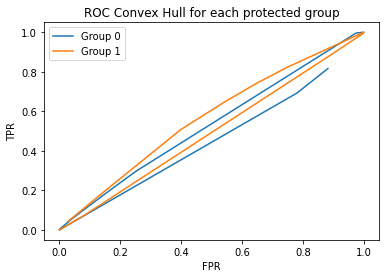

In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def compute_ROC(score, Y, A, a, t):
    """
    Compute FPR and TPR for a given threshold 't' and protected attribute 'a'
    """
    condition_neg = (A == a) & (Y == 0)
    condition_pos = (A == a) & (Y == 1)
    
    FPR = np.mean(score[condition_neg] > t)
    TPR = np.mean(score[condition_pos] > t)
    
    return (FPR, TPR)

def compute_ROC_convex_hull(score, Y, A, a):
    """
    Compute the convex hull of the ROC curve for protected attribute 'a'
    """
    thresholds = np.linspace(0, 1, 100)
    points = np.array([compute_ROC(score, Y, A, a, t) for t in thresholds])
    
    hull = ConvexHull(points)
    
    return hull

# Example usage
score = np.random.rand(1000)  # Some random scores for demonstration
Y = np.random.randint(0, 2, 1000)
A = np.random.randint(0, 2, 1000)  # Assuming binary protected attribute

# For each protected group 'a', plot the convex hull of its ROC curve
for a in [0, 1]:
    hull = compute_ROC_convex_hull(score, Y, A, a)
    plt.plot(hull.points[hull.vertices,0], hull.points[hull.vertices,1], label=f'Group {a}')
    
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Convex Hull for each protected group')
plt.legend()
plt.show()


# Procedure: Deriving from a Binary Predictor

From the Hardt et. al paper.

## Step 1: Define the γ Function
Given a binary predictor `Yhat` and a binary protected attribute `A`, define the function:

γ_a(Yhat) = (
Pr{ Yhat = 1 | A=a, Y=0 },
Pr{ Yhat = 1 | A=a, Y=1 }
)

Where:
- The first component is the **false positive rate** within the demographic satisfying `A=a`.
- The second component is the **true positive rate** within `A=a`.

## Step 2: Create the Convex Polytope
For each value of `a` in {0,1}, construct the convex polytope `P_a(Yhat)` defined as the convex hull of the four vertices:
- (0,0)
- γ_a(Yhat)
- γ_a(1-Yhat)
- (1,1)

## Step 3: Determine Derived Predictors
A predictor `Ytilde` is considered derived if and only if, for all `a` in {0,1}, the point `γ_a(Ytilde)` lies inside the polytope `P_a(Yhat)`.

## Step 4: Optimization for Equalized Odds
Find the optimal derived predictor with equalized odds by solving the following linear program:

minimize: E[loss(Ytilde, Y)]
subject to:
∀a in {0,1}: γ_a(Ytilde) ∈ P_a(Yhat)
γ_0(Ytilde) = γ_1(Ytilde)

Where `E[loss(Ytilde, Y)]` represents the expected loss of the derived predictor.

**Note**: The solution provides an optimal equalized odds predictor derived from `Yhat` and `A`.

## Step 5: Optimization for Equal Opportunity
The optimization process for equal opportunity is similar but requires the constraint `γ_0(Ytilde)_2 = γ_1(Ytilde)_2`.


In [2]:
import numpy as np
from scipy.optimize import linprog

def gamma_a(Yhat, A, Y, a):
    """ Compute the gamma function for given value of A=a """
    FPR = np.mean([(Yhat_i == 1 and Y_i == 0) for Yhat_i, A_i, Y_i in zip(Yhat, A, Y) if A_i == a])
    TPR = np.mean([(Yhat_i == 1 and Y_i == 1) for Yhat_i, A_i, Y_i in zip(Yhat, A, Y) if A_i == a])
    return FPR, TPR

def equalized_odds_optimizer(Yhat, A, Y):
    gamma_0 = gamma_a(Yhat, A, Y, 0)
    gamma_1 = gamma_a(Yhat, A, Y, 1)
    
    A_eq = [[1, -1, 0, 0], 
            [0, 0, 1, -1]]
    b_eq = [0, 0]
    
    c = [1, 1, 1, 1]
    
    res = linprog(c, A_eq=A_eq, b_eq=b_eq)
    
    return res.x

Yhat = np.array([1, 0, 1, 0, 1, 0])
A = np.array([0, 0, 1, 1, 0, 1])
Y = np.array([1, 0, 1, 0, 0, 1])

result = equalized_odds_optimizer(Yhat, A, Y)
print(result)


[ 0. -0.  0. -0.]


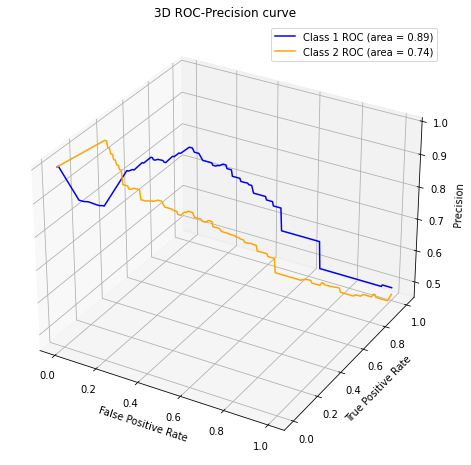

In [31]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def compute_roc_and_precision(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    precision_interp = np.interp(tpr, recall[::-1], precision[::-1])
    return fpr, tpr, precision_interp, auc(fpr, tpr)

X1, y1 = make_classification(n_samples=500, n_features=15, n_classes=2, random_state=42, class_sep=1.0)
X2, y2 = make_classification(n_samples=500, n_features=15, n_redundant=5, n_classes=2, random_state=42, class_sep=0.4)

A1 = np.ones(y1.shape)
A2 = 2 * np.ones(y2.shape)

X = np.vstack([X1, X2])
y = np.hstack([y1, y2])
A = np.hstack([A1, A2])

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.5, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]

mask_class1 = A_test == 1
mask_class2 = A_test == 2
fpr1, tpr1, precision1, roc_auc1 = compute_roc_and_precision(y_test[mask_class1], y_prob[mask_class1])
fpr2, tpr2, precision2, roc_auc2 = compute_roc_and_precision(y_test[mask_class2], y_prob[mask_class2])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(fpr1, tpr1, precision1, label=f'Class 1 ROC (area = {roc_auc1:.2f})', color='blue')
ax.plot(fpr2, tpr2, precision2, label=f'Class 2 ROC (area = {roc_auc2:.2f})', color='orange')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_zlabel('Precision')
ax.set_title('3D ROC-Precision curve')
ax.legend()
plt.show()

In [34]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=fpr1, y=tpr1, z=precision1, 
                           mode='lines', 
                           name=f'Class 1 ROC (area = {roc_auc1:.2f})',
                           line=dict(color='blue')))

fig.add_trace(go.Scatter3d(x=fpr2, y=tpr2, z=precision2, 
                           mode='lines', 
                           name=f'Class 2 ROC (area = {roc_auc2:.2f})',
                           line=dict(color='orange')))

fig.update_layout(scene=dict(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        zaxis_title='Precision'),
    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


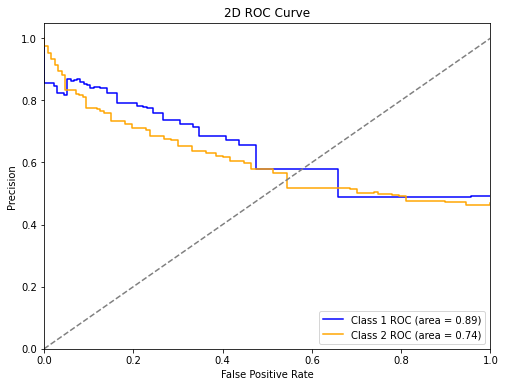

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr1, precision1, color='blue', label=f'Class 1 ROC (area = {roc_auc1:.2f})')
plt.plot(fpr2, precision2, color='orange', label=f'Class 2 ROC (area = {roc_auc2:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('Precision')
plt.title('2D ROC Curve')
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()


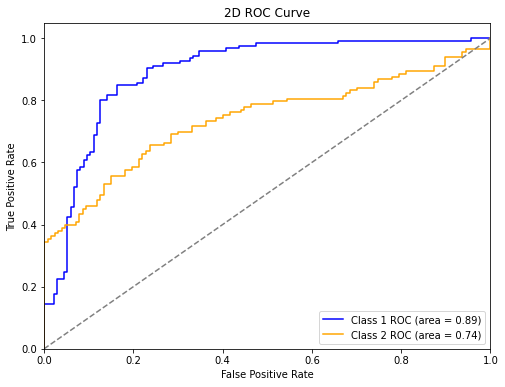

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(fpr1, tpr1, color='blue', label=f'Class 1 ROC (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='orange', label=f'Class 2 ROC (area = {roc_auc2:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('2D ROC Curve')
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()
